Simulates a memory experiment (much like what we covered in class) and uses models to understand how people recognize words they've seen before


hit = yes to old item (correctly remember the word they saw)
miss = no to old item (forgot they saw the word before)
false alarm = yes to new (thought they saw a word they didnt)
correct reject = No to new item (correctly said a new word wasnt shown)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

np.random.seed(2023)

def simulate_memory_task(n_old, n_new, d_old=0.7, d_new=0.6, g=0.3):
    """Simulate data from a recognition memory task """

    detections = np.random.binomial(n=1, p=d_old, size=n_old) #detect old items
    hits = sum(detections + (1-detections) * np.random.binomial(n=1, p=g, size=n_old)) #hit or guess
    misses = n_old - hits

    if d_new > 0:  # 2HT model
        detections = np.random.binomial(n=1, p=d_new, size=n_new)
        false_alarms = sum((1-detections) * np.random.binomial(n=1, p=g, size=n_new))
    else:  # 1HT model
        false_alarms = sum(np.random.binomial(n=1, p=g, size=n_new))
    
    correct_rejections = n_new - false_alarms
    
    return {
        'hits': int(hits),
        'misses': int(misses),
        'false_alarms': int(false_alarms),
        'correct_rejections': int(correct_rejections),
        'n_old': n_old,
        'n_new': n_new
    }

# Simulate data
n_old = 15
n_new = 15
data = simulate_memory_task(n_old=n_old, n_new=n_new)

print("Memory task results:")
print(f"Hits: {data['hits']}/{data['n_old']} ({data['hits']/data['n_old']:.2f})")
print(f"Misses: {data['misses']}/{data['n_old']} ({data['misses']/data['n_old']:.2f})")
print(f"False Alarms: {data['false_alarms']}/{data['n_new']} ({data['false_alarms']/data['n_new']:.2f})")
print(f"Correct Rejections: {data['correct_rejections']}/{data['n_new']} ({data['correct_rejections']/data['n_new']:.2f})")

Memory task results:
Hits: 13/15 (0.87)
Misses: 2/15 (0.13)
False Alarms: 2/15 (0.13)
Correct Rejections: 13/15 (0.87)


In [4]:
model_1ht_code = """
data {
  int<lower=0> n_old;      // Number of old items
  int<lower=0> n_new;      // Number of new items
  int<lower=0> hits;       // Number of hits
  int<lower=0> misses;     // Number of misses
  int<lower=0> false_alarms;       // Number of false alarms
  int<lower=0> correct_rejections; // Number of correct rejections
}

parameters {
  real<lower=0, upper=1> d;  // Detection parameter
  real<lower=0, upper=1> g;  // Guessing parameter
}

model {
  // Priors
  d ~ beta(1, 1);  // Uninformative prior
  g ~ beta(1, 1);  // Uninformative prior
  
  // Likelihood for old items
  hits ~ binomial(n_old, d + (1-d) * g);
  
  // Likelihood for new items
  false_alarms ~ binomial(n_new, g);
}

generated quantities {
  // Predicted counts
  int<lower=0> pred_hits = binomial_rng(n_old, d + (1-d) * g);
  int<lower=0> pred_misses = n_old - pred_hits;
  int<lower=0> pred_false_alarms = binomial_rng(n_new, g);
  int<lower=0> pred_correct_rejections = n_new - pred_false_alarms;
}
"""
model_2ht_code = """
data {
  int<lower=0> n_old;      // Number of old items
  int<lower=0> n_new;      // Number of new items
  int<lower=0> hits;       // Number of hits
  int<lower=0> misses;     // Number of misses
  int<lower=0> false_alarms;       // Number of false alarms
  int<lower=0> correct_rejections; // Number of correct rejections
}

parameters {
  real<lower=0, upper=1> d_old;  // Detection parameter for old items
  real<lower=0, upper=1> d_new;  // Detection parameter for new items
  real<lower=0, upper=1> g;      // Guessing parameter
}

model {
  // Priors
  d_old ~ beta(1, 1);  // Uninformative prior
  d_new ~ beta(1, 1);  // Uninformative prior
  g ~ beta(1, 1);      // Uninformative prior
  
  // Likelihood for old items
  hits ~ binomial(n_old, d_old + (1-d_old) * g);
  
  // Likelihood for new items
  correct_rejections ~ binomial(n_new, d_new + (1-d_new) * (1-g));
}

generated quantities {
  // Predicted counts
  int<lower=0> pred_hits = binomial_rng(n_old, d_old + (1-d_old) * g);
  int<lower=0> pred_misses = n_old - pred_hits;
  int<lower=0> pred_false_alarms = binomial_rng(n_new, (1-d_new) * g);
  int<lower=0> pred_correct_rejections = n_new - pred_false_alarms;
}
"""

In [5]:

stan_data = {
    'n_old': data['n_old'],
    'n_new': data['n_new'],
    'hits': data['hits'],
    'misses': data['misses'],
    'false_alarms': data['false_alarms'],
    'correct_rejections': data['correct_rejections']
}

# Build and sample from the 1HT model
model_1ht = stan.build(model_1ht_code, data=stan_data)
fit_1ht = model_1ht.sample(num_chains=4, num_samples=2000, num_warmup=1000)

# Build and sample from the 2HT model
model_2ht = stan.build(model_2ht_code, data=stan_data)
fit_2ht = model_2ht.sample(num_chains=4, num_samples=2000, num_warmup=1000)



Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!


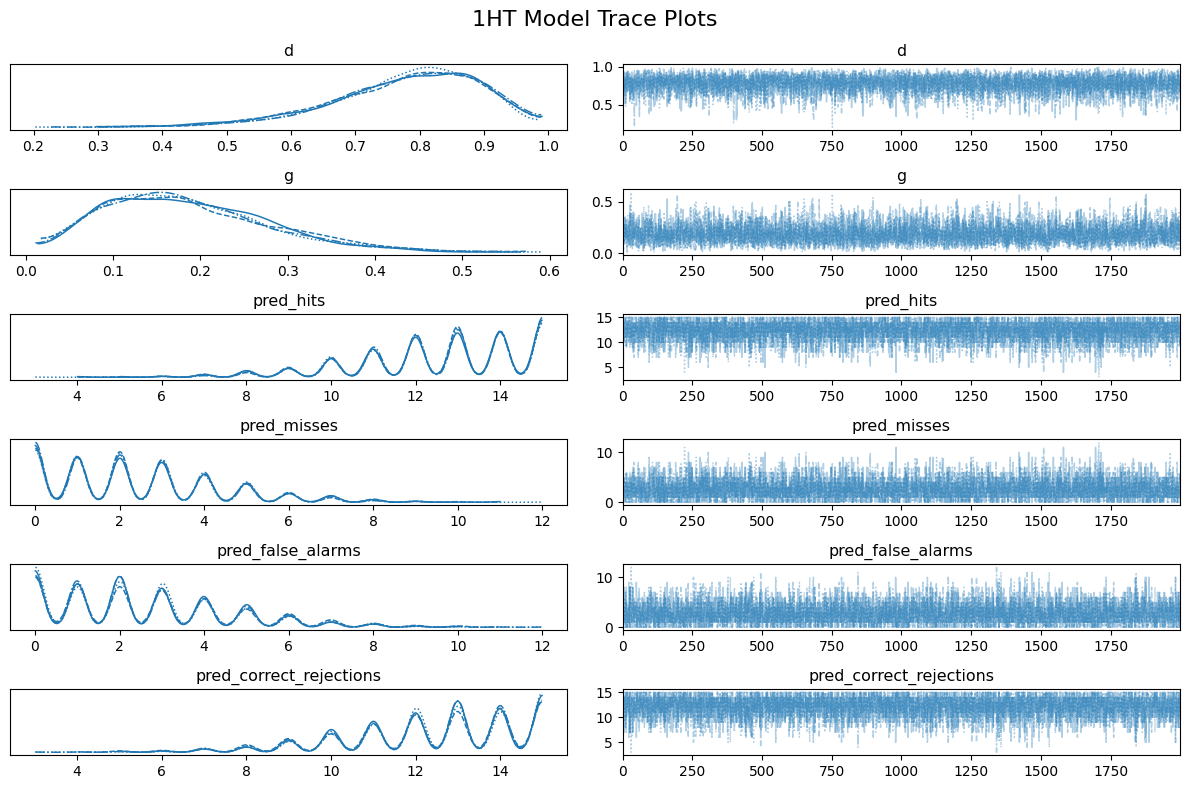

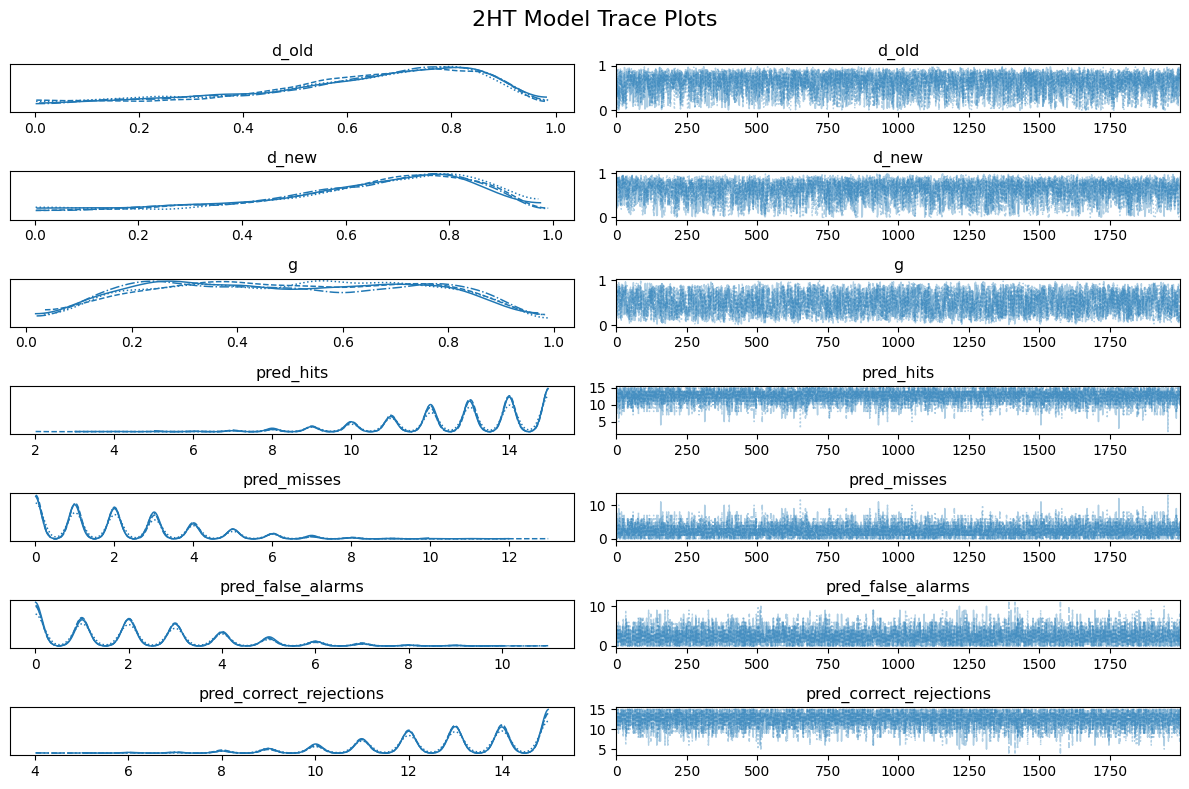

In [7]:
az.plot_trace(fit_1ht, figsize=(12, 8))
plt.suptitle("1HT Model Trace Plots", fontsize=16)
plt.tight_layout()

az.plot_trace(fit_2ht, figsize=(12, 8))
plt.suptitle("2HT Model Trace Plots", fontsize=16)
plt.tight_layout()

In [13]:

az.summary(fit_1ht)
az.summary(fit_2ht)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_old,0.621,0.230,0.172,0.964,0.004,0.003,3229.0,3084.0,1.0
d_new,0.604,0.236,0.136,0.953,0.004,0.003,3209.0,3121.0,1.0
g,0.491,0.238,0.095,0.886,0.005,0.002,2714.0,4377.0,1.0
pred_hits,12.645,1.832,9.000,15.000,0.021,0.017,7868.0,7605.0,1.0
pred_misses,2.355,1.832,0.000,6.000,0.021,0.017,7868.0,7262.0,1.0
pred_false_alarms,2.369,1.850,0.000,6.000,0.021,0.019,7477.0,6843.0,1.0
pred_correct_rejections,12.631,1.850,9.000,15.000,0.021,0.019,7477.0,6943.0,1.0
